In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [11]:
# ==========================================
# 1. HARDWARE & PHYSICS CONFIG
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Hardware: {device}")

# Biophysics Constants
ALPHA_CORTEX  = 0.01  # Thermal DIffusivity (outer)
ALPHA_MEDULLA = 0.02  # Thermal Diffusivity (Inner)
H_COEFF       = 5.0   # COnvection coffecient
T_INF         = -1.0  # Liquid Nitrogen Temperature
T_INITIAL     = 1.0   # Body Temperature (37C Normalized)
T_FREEZE      = 0.0   # Freezing point (0C)

# Advanced Physics
LATENT_HEAT   = 10.0  # Magnitude of energy released during freezing
PHASE_WIDTH   = 0.1   # Sharpness of the freezing transition
PERFUSION_RATE = 0.5  # Blood flow warming rate (Pennes Source)

Hardware: cuda


In [12]:
# ==========================================
# 2. RESNET ARCHITECTURE (SiLU + Skip)
# ==========================================
class ResNetBlock(nn.Module):
    def __init__(self, neurons):
        super(ResNetBlock, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(neurons, neurons),
            nn.SiLU(), 
            nn.Linear(neurons, neurons),
            nn.SiLU()
        )
    def forward(self, x):
        return x + self.layer(x) 

class BioPINN(nn.Module):
    def __init__(self, layers=4, neurons=64):
        super(BioPINN, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(3, neurons), nn.SiLU())
        self.res_blocks = nn.ModuleList([ResNetBlock(neurons) for _ in range(layers)])
        self.output_layer = nn.Linear(neurons, 1)

    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)
        out = self.input_layer(inputs)
        for block in self.res_blocks:
            out = block(out)
        return self.output_layer(out)

In [13]:
# ==========================================
# 3. GEOMETRY & PHYSICS LOSS
# ==========================================
def get_kidney_points(n_points):
    """Generates random points inside the bean shape on Device."""
    points_x, points_y = [], []
    count = 0
    while count < n_points:
        xt = torch.rand(n_points, 1, device=device) * 2 - 1
        yt = torch.rand(n_points, 1, device=device) * 2 - 1
        
        y_bent = yt - 0.2 * torch.sin(3 * xt)
        mask = ((xt / 0.8)**2 + (y_bent / 0.5)**2) <= 1.0
        
        valid_x = xt[mask].unsqueeze(1)
        valid_y = yt[mask].unsqueeze(1)
        points_x.append(valid_x)
        points_y.append(valid_y)
        count += len(valid_x)
    return torch.cat(points_x)[:n_points], torch.cat(points_y)[:n_points]

def physics_loss(model, x, y, t):
    x.requires_grad = True; y.requires_grad = True; t.requires_grad = True
    u = model(x, y, t)
    
    # Derivatives
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # 1. Heterogeneous Material
    r = torch.sqrt(x**2 + y**2)
    alpha = ALPHA_CORTEX + (ALPHA_MEDULLA - ALPHA_CORTEX) * torch.sigmoid(10 * (0.4 - r))
    
    # 2. Phase Change (Apparent Heat Capacity)
    spike = LATENT_HEAT * torch.exp(-((u - T_FREEZE)**2) / (2 * PHASE_WIDTH**2))
    C_eff = 1.0 + spike
    
    # 3. Bioheat Source (Perfusion stops at freezing)
    perfusion_active = torch.sigmoid(10 * u) 
    Q_blood = PERFUSION_RATE * perfusion_active * (T_INITIAL - u)
    
    # PDE Residual
    residual_pde = (C_eff * u_t) - (alpha * (u_xx + u_yy)) - Q_blood
    loss_pde = torch.mean(residual_pde ** 2)
    
    # Boundary (Convection Proxy)
    theta = torch.rand(len(x), 1, device=device) * 2 * np.pi
    xb = 0.8 * torch.cos(theta)
    yb = 0.5 * torch.sin(theta) + 0.2 * torch.sin(3 * 0.8 * torch.cos(theta))
    tb = torch.rand(len(x), 1, device=device)
    
    u_bound = model(xb, yb, tb)
    target = T_INF + (T_INITIAL - T_INF) * torch.exp(-H_COEFF * tb)
    loss_bc = torch.mean((u_bound - target) ** 2)
    
    # Initial Condition
    x0, y0 = get_kidney_points(len(x)//5)
    t0 = torch.zeros_like(x0)
    loss_ic = torch.mean((model(x0, y0, t0) - T_INITIAL) ** 2)
    
    return loss_pde + loss_bc + loss_ic

In [14]:
# ==========================================
# 4. HYPERPARAMETER TUNING (The "AutoML" Step)
# ==========================================
def run_trial(config):
    print(f"  Testing: {config}")
    model = BioPINN(layers=config['layers'], neurons=config['neurons']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    
    # Short run (1000 epochs) to test convergence speed
    x_p, y_p = get_kidney_points(2000)
    t_p = torch.rand(2000, 1, device=device)
    
    final_loss = 0
    for _ in range(1000):
        optimizer.zero_grad()
        loss = physics_loss(model, x_p, y_p, t_p)
        loss.backward()
        optimizer.step()
        final_loss = loss.item()
    return final_loss, model

param_grid = {
    'lr': [0.001, 0.0005],
    'layers': [2, 4, 6],
    'neurons': [32, 64]
}

print("STARTING HYPERPARAMETER TUNING (Random Search)")
best_loss = float('inf')
best_config = {}
best_model = None

# Run 3 Trials
for i in range(3):
    config = {k: random.choice(v) for k, v in param_grid.items()}
    loss, model = run_trial(config)
    print(f"  > Trial {i+1} Loss: {loss:.6f}")
    
    if loss < best_loss:
        best_loss = loss
        best_config = config
        # We start fresh for the final training, but keep the config
        
print(f"Winner Config: {best_config}")

STARTING HYPERPARAMETER TUNING (Random Search)
  Testing: {'lr': 0.001, 'layers': 6, 'neurons': 32}
  > Trial 1 Loss: 0.693503
  Testing: {'lr': 0.0005, 'layers': 6, 'neurons': 32}
  > Trial 2 Loss: 0.706222
  Testing: {'lr': 0.0005, 'layers': 6, 'neurons': 64}
  > Trial 3 Loss: 0.755290
Winner Config: {'lr': 0.001, 'layers': 6, 'neurons': 32}


In [15]:
# ==========================================
# 5. FINAL TRAINING 
# ==========================================
final_model = BioPINN(layers=best_config['layers'], neurons=best_config['neurons']).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_config['lr'])

print(" Starting Final High-Fidelity Training...")
x_phys, y_phys = get_kidney_points(5000)
t_phys = torch.rand(5000, 1, device=device)

loss_history = []
for epoch in range(5001):
    optimizer.zero_grad()
    loss = physics_loss(final_model, x_phys, y_phys, t_phys)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

 Starting Final High-Fidelity Training...
Epoch 0: Loss = 1.706818
Epoch 1000: Loss = 0.694834
Epoch 2000: Loss = 0.345125
Epoch 3000: Loss = 0.110001
Epoch 4000: Loss = 0.664775
Epoch 5000: Loss = 0.020495


Text(0.5, 1.0, "Optimized Kidney Model (Config: {'lr': 0.001, 'layers': 6, 'neurons': 32})")

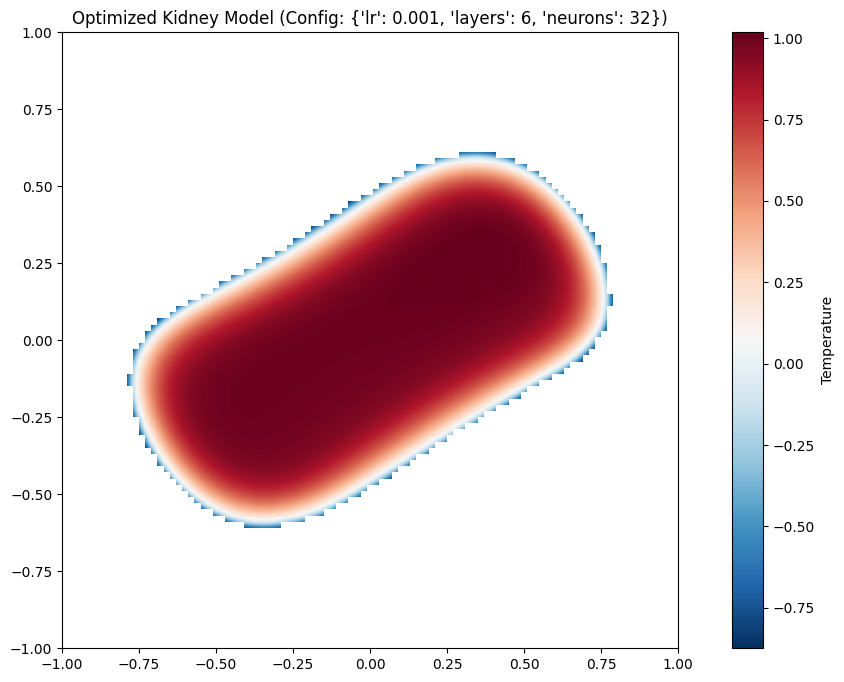

In [20]:
# ==========================================
# 6. VISUALIZATION
# ==========================================

x_grid = np.linspace(-1, 1, 100)
y_grid = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = torch.tensor(X.flatten()[:, None], dtype=torch.float32, device=device)
Y_flat = torch.tensor(Y.flatten()[:, None], dtype=torch.float32, device=device)
T_flat = torch.ones_like(X_flat) * 0.5 # t=0.5

final_model.eval()
with torch.no_grad():
    U_pred = final_model(X_flat, Y_flat, T_flat).cpu().numpy().reshape(X.shape)

# Mask
Y_bent = Y - 0.2 * np.sin(3 * X)
mask = ((X / 0.8)**2 + (Y_bent / 0.5)**2) <= 1.0
U_masked = np.where(mask, U_pred, np.nan)

plt.figure(figsize=(14, 8))
plt.subplot(1, 1, 1)
plt.imshow(U_masked, interpolation='bilinear', cmap='RdBu_r', origin='lower', extent=[-1, 1, -1, 1])
plt.colorbar(label='Temperature')
plt.title(f'Optimized Kidney Model (Config: {best_config})')

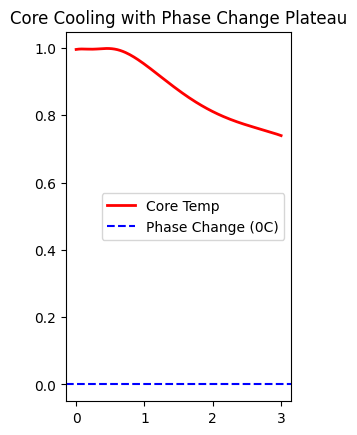

Done.


In [17]:
# Cooling Curve
plt.subplot(1, 2, 2)
t_val = np.linspace(0, 3, 150)
t_vec = torch.tensor(t_val[:, None], dtype=torch.float32, device=device)
x_c = torch.zeros_like(t_vec); y_c = torch.zeros_like(t_vec)
with torch.no_grad():
    u_c = final_model(x_c, y_c, t_vec).cpu().numpy()

plt.plot(t_val, u_c, 'r-', linewidth=2, label='Core Temp')
plt.axhline(y=0.0, color='blue', linestyle='--', label='Phase Change (0C)')
plt.legend()
plt.title('Core Cooling with Phase Change Plateau')
plt.savefig('final_god_mode_results.png', dpi=300)
plt.show()
print("Done.")